In [7]:
using SparseArrays
using LinearAlgebra
using Plots
using Random, Distributions
using Distributed
using Statistics
using BlockDiagonals
using IndirectArrays, FileIO, Colors

In [8]:
ħ = 1.054E-34; μB = 9.274E-24; gₑ = 2.0023; μ₀=1.256637E-6;
γ = gₑ*μB/ħ; nm = 1E-9; kB = 1.381E-23

x̂ = [1;0;0]; ŷ = [0;1;0]; ẑ = [0;0;1];

In [9]:
Random.seed!(123)
g = Normal();
⊗(A,B) = kron(A,B)

⊗ (generic function with 1 method)

In [231]:
crossmat(A::Vector{Float64}) = [0 -A[3] A[2]; A[3] 0 -A[1]; -A[2] A[1] 0]

function ivec_to_index(p::NamedTuple, ivec::Vector{Int})
    ix = ivec[1]; iy = ivec[2]
    return ix + 1  + iy*p.nx
end


function ivec_to_position(p::NamedTuple, ivec::Vector{Int})
    return ivec[1]*p.ax*x̂ + ivec[2]*p.ay*ŷ
end

function idevice_to_M_device(M::Vector{Float64},idevice::Int)
    return M[(3*idevice-2):(3*idevice)]
end

function ivec_to_M_device(p::NamedTuple, M::Vector{Float64},ivec::Vector{Int})
    idevice = ivec_to_index(p, ivec)
    return idevice_to_M_device(M, idevice)
end

function H_from_deviceA_on_deviceB(p::NamedTuple, ivecA::Vector{Int}, ivecB::Vector{Int}, M::Vector{Float64})
    rA = ivec_to_position(p, ivecA)
    rB = ivec_to_position(p, ivecB)
    #println("ivecA = $ivecA, ivecB = $ivecB")
    ΔR = rB-rA; R = norm(ΔR); r̂ = ΔR/R
    m̂A = ivec_to_M_device(p, M, ivecA)
    #println("mA = $(m̂A), rhat = $(r̂); R = $R")
    H = -p.m*(m̂A)/(4*π*R^5)
    #H = p.m*(3*r̂*(m̂A⋅r̂) - m̂A)/(4*π*R^3)
    #display(H)
    return H
end

function Agen(p::NamedTuple, M::Vector{Float64}, t::Float64)
    #rowvals = Int[]
    #colvals = Int[]
    #zvals = Float64[]
    blockMatrices = Vector{Matrix{Float64}}(undef,p.nx*p.ny)
    # you could put a @Threads.threads macro here
    for ix = 0:(p.nx-1)
        for iy = 0:(p.ny-1)
            ivec = [ix;iy]
            idevice = ivec_to_index(p,ivec)
            #println("Central device # = $idevice, ivec = $ivec")
            m̂_device = idevice_to_M_device(M,idevice)
            # now let's build the Heff 
            random_vector = rand(g,3); random_vector = random_vector/norm(random_vector);
            Htherm = random_vector*√(2*μ₀*p.α*p.T*kB/(p.Ms*μ₀*p.Δt*p.ΔV*abs(γ)))/μ₀; 
            H_anisotropy = (2*p.Ku/(μ₀*p.Ms))*m̂_device[3]*ẑ
            Heff = Htherm + H_anisotropy + p.B_app(t)/μ₀
            #println("ivec = $ivec, Heff = $Heff")
            # now add in stray fields from neighbors
            Δivec = zeros(2)
            for Δivec ∈ [[-1,0],[1,0],[0,-1],[0,1]]
                ivecB = ivec + Δivec
                if(ivecB[1]<=(p.nx-1) && ivecB[1]>=0 && ivecB[2]<=(p.ny-1) && ivecB[2]>=0)
                    Heff += p.C*H_from_deviceA_on_deviceB(p, ivecB, ivec, M)
                end
            end
            #=uncomment if you want faithful stray fields
            for Δix ∈ [-1,1]
                for Δiy ∈ [-1,1]
                    ivecB = ivec + [Δix; Δiy]
                    if(ivecB[1]<=(p.nx-1) && ivecB[1]>=0 && ivecB[2]<=(p.ny-1) && ivecB[2]>=0)
                        Heff += p.C*H_from_deviceA_on_deviceB(p, ivecB, ivec, M)
                    end
                end
            end=#
            #println("ivec = $ivec, Heff = $Heff")
            # THIS IS THE LL EQUATION 
            A_device = γ*crossmat(μ₀*Heff)  + p.λ*crossmat(cross(m̂_device,μ₀*Heff))
            # and we throw it onto the big diagonal matrix 
            blockMatrices[idevice] = copy(A_device)
            #=for icol = 1:3
                for irow = 1:3
                    push!(colvals, 3*idevice-3+icol)
                    push!(rowvals, 3*idevice-3+irow)
                    push!(zvals, A_device[irow, icol])
                end
            end=#
        end
    end
    return BlockDiagonal(blockMatrices)
    #return sparse(rowvals, colvals, zvals)
    #return sparse(rowvals, colvals, zvals)
end

function more_parameters(p::NamedTuple)
    λ = p.α*γ/(μ₀*p.Ms)
    ΔV = p.Δy*p.Δx*p.Δz
    m = p.Ms*ΔV
    tvals = collect([t for t = 0:p.Δt:p.t_final]); nT = size(tvals)[1]
    newparams = merge(p, (λ = λ, ΔV = ΔV, m = m, nT = nT))
    display(newparams)
    return newparams
end

function heun_integrate(p::NamedTuple)
    p = more_parameters(p)
    tvals = collect([t for t = 0:p.Δt:p.t_final]); nT = size(tvals)[1]
    println("Integrating over $nT timesteps")
    nD = p.nx*p.ny
    Mvals = zeros(nD*3,nT)
    # initialize it with something 
    M₀ = ones(nD)⊗[1;0;0]
    #=M₀ = rand(g, 3*nD)
    # normalize each m\hat
    for iD ∈ 1:nD
        m̂ = M₀[(1+3*iD-3):(3*iD)]
        M₀[(1+3*iD-3):(3*iD)] = m̂/norm(m̂)
    end=#
    for it ∈ eachindex(tvals)
        #println("t = $(tvals[it])")
        t = tvals[it]
        f₀ = Agen(p,M₀,t)*M₀
        M̃₁ = M₀ + p.Δt*f₀
        for iD ∈ 1:nD
            m̂ = M̃₁[(1+3*iD-3):(3*iD)]
            M̃₁[(1+3*iD-3):(3*iD)] = m̂/norm(m̂)
        end
        #M̃₁ = M₀ + Δt*Agen(p,M₀)*M₀
        M₁ = M₀ + (p.Δt/2)*(f₀+Agen(p,M̃₁,t)*M̃₁)
        # and normalize
        for iD ∈ 1:nD
            m̂ = M₁[(1+3*iD-3):(3*iD)]
            M₁[(1+3*iD-3):(3*iD)] = m̂/norm(m̂)
        end
        Mvals[:,it] = M₁
        M₀ = deepcopy(M₁)
    end
    return Mvals
end

heun_integrate (generic function with 1 method)

In [232]:
function Mvec_to_matrices(p::NamedTuple, M::Matrix{Float64},dim::Int=3)
    nT = size(M)[2]
    Mzgrid = zeros((p.nx,p.ny,nT))
    display(size(M))
    for it = 1:nT
        Mzs_at_t = M[dim:3:(p.nx*p.ny*3),it]
        #display(sizeof(Mzs_at_t))
        #Mzs_at_t = M[(3):3:(p.nx*p.ny),it]
        Mzgrid[:,:,it] = reshape(Mzs_at_t,(p.nx,p.ny))
    end
    return Mzgrid
end

function animate_Mzvals(p::NamedTuple, Mzgrid::Array{Float64, 3})
    nT = size(Mzgrid)[3]
    anim = @animate for it ∈ 1:nT
        heatmap(Mzgrid[:,:,it]',clim=(-1,1), cmap=:coolwarm, title="$it")
    end
    return gif(anim, "anim_fps15.gif", fps = 30)
end

function sum_Mz_time(p::NamedTuple, Mzgrid::Array{Float64,3})
    nT = size(Mzgrid)[3]
    avgMzs = [mean(Mzgrid[:,:,it]) for it = 1:nT]
    stdMzs = [std(Mzgrid[:,:,it]) for it = 1:nT]
    plot(avgMzs, label="Avg M");
    plot!(stdMzs, ylim=(-1.1,1.1), label="Std(M)")
end

function final_Mzvals(p::NamedTuple, Mzgrid::Array{Float64, 3})
    nT = size(Mzgrid)[3]
    return heatmap(Mzgrid[:,:,nT],clim=(-1,1), cmap=:coolwarm, title="finaltime")
end

function isolate_device(p::NamedTuple, M::Array, ivec::Vector{Int})
    nT = size(M)[2]
    M_over_t = zeros(3,nT)
    idevice = ivec_to_index(p, ivec)
    for it = 1:nT
        M_over_t[:,it] = M[(3*idevice-2):(3*idevice),it]
    end
    return M_over_t
end

function plot_single_device(p::NamedTuple, M::Array, ivec::Vector{Int})
    nT = size(M)[2]
    M_t = isolate_device(p,M,ivec)
    plot(M_t[1,:], M_t[2,:], M_t[3,:], xlim=(-1.1,1.1), ylim=(-1.1,1.1), zlim=(-1.1,1.1), ms=5)
    #anim = @animate for it ∈ 1:nT
    #    scatter(M_t[1,it], M_t[2,it], M_t[3,it], title="$it",ms=5)
    #end
   # return gif(anim, "anim_singledevice_fps15.gif", fps = 120)
end


plot_single_device (generic function with 1 method)

In [289]:
parameters = (Ms = 1.5E6, Δz = 1.5*nm, Δx = 20*nm, Δy = 20*nm, μᵣ = 0.5, Δt = 2E-12, t_final = 20E-9, T=10,
nx = 10, ny = 5, ax = 30*nm, ay=30*nm, α = 0.1, Ku = 0.1E6, C=-2E-16, B_app = (B_app(t::Float64)= 0.00*ẑ));

In [290]:
Mvals = heun_integrate(parameters);

(Ms = 1.5e6, Δz = 1.5000000000000002e-9, Δx = 2.0e-8, Δy = 2.0e-8, μᵣ = 0.5, Δt = 2.0e-12, t_final = 2.0e-8, T = 10, nx = 10, ny = 5, ax = 3.0000000000000004e-8, ay = 3.0000000000000004e-8, α = 0.1, Ku = 100000.0, C = -2.0e-16, B_app = B_app, λ = 9.346618708800278e9, ΔV = 6.000000000000001e-25, m = 9.000000000000002e-19, nT = 10001)

Integrating over 10001 timesteps

In [291]:
Mzgrid = Mvec_to_matrices(parameters,Mvals,1);

(150, 10001)

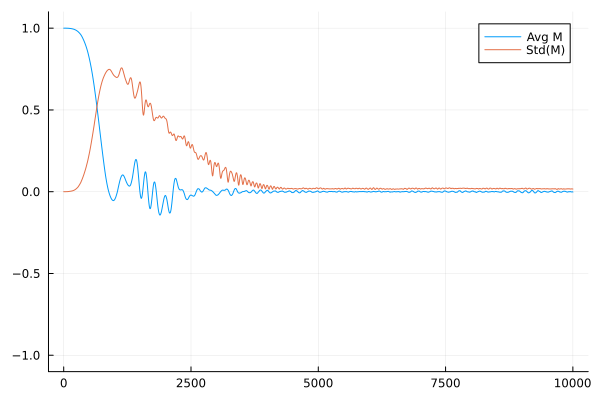

In [292]:
fig = sum_Mz_time(parameters, Mzgrid)
plot_single_device(parameters, Mvals, [0,0]);
display(fig)

In [293]:
function fullColorAnimation(p::NamedTuple, Mvals::Matrix{Float64})
    nT = size(Mvals)[2]
    Mgrid = zeros((3,p.nx,p.ny,nT))
    Mgrid[1,:,:,:] = (Mvec_to_matrices(p,Mvals,1))
    Mgrid[2,:,:,:] = (Mvec_to_matrices(p,Mvals,2))
    Mgrid[3,:,:,:] = (Mvec_to_matrices(p,Mvals,3).+1)/2
    H = (atan.(Mgrid[1,:,:,:], Mgrid[2,:,:,:]).+π)*(180/π)
    S = ones(size(Mgrid[1,:,:,:]))
    L = Mgrid[3,:,:,:]
    #colorarray = IndirectArray(RGB.(Mgrid), [colorant"red", colorant"green", colorant"blue"])
    save("myanimation.gif", HSL.(H,S,L); fps=40)
end

fullColorAnimation (generic function with 1 method)

In [294]:
fullColorAnimation(parameters, Mvals)

(150, 10001)

(150, 10001)

(150, 10001)

In [154]:
#animate_Mzvals(parameters, Mzgrid)

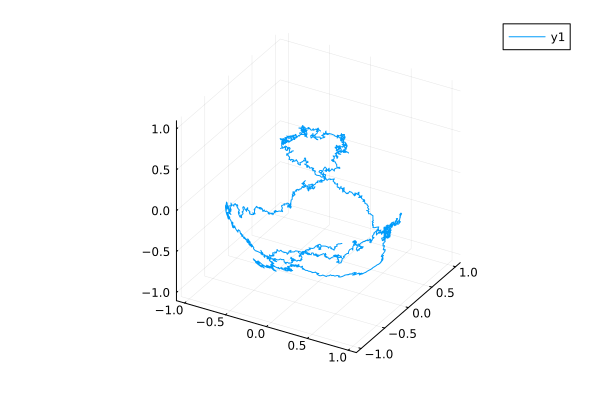

In [245]:
plot_single_device(parameters, Mvals, [5,0])

In [20]:
checkerboard_vector = ones(50)⊗[0;1]
checkerboard_matrix =   ones(50)⊗[1;0]*(ones(50)⊗[0;1])' + ones(50)⊗[0;1]*(ones(50)⊗[1;0])'.-.5 #+ ones(50)⊗[0;1]*(ones(50)⊗[0;1])'
rand_matrix = rand(Bool,800,800).-0.5

800×800 Matrix{Float64}:
 -0.5  -0.5   0.5   0.5  -0.5  -0.5  …   0.5   0.5  -0.5  -0.5   0.5  -0.5
  0.5   0.5   0.5   0.5  -0.5  -0.5      0.5   0.5   0.5   0.5  -0.5   0.5
  0.5  -0.5   0.5   0.5  -0.5  -0.5      0.5  -0.5  -0.5  -0.5   0.5   0.5
 -0.5   0.5  -0.5   0.5   0.5   0.5     -0.5   0.5  -0.5  -0.5  -0.5  -0.5
  0.5  -0.5  -0.5   0.5  -0.5  -0.5     -0.5   0.5  -0.5  -0.5   0.5  -0.5
 -0.5   0.5  -0.5  -0.5  -0.5   0.5  …  -0.5   0.5  -0.5  -0.5   0.5  -0.5
  0.5   0.5   0.5   0.5  -0.5  -0.5     -0.5  -0.5  -0.5   0.5   0.5  -0.5
  0.5   0.5   0.5   0.5   0.5   0.5     -0.5  -0.5   0.5  -0.5  -0.5   0.5
 -0.5  -0.5  -0.5   0.5  -0.5   0.5      0.5   0.5  -0.5  -0.5   0.5   0.5
  0.5  -0.5  -0.5  -0.5  -0.5   0.5     -0.5  -0.5  -0.5  -0.5   0.5  -0.5
  ⋮                             ⋮    ⋱         ⋮                      
  0.5   0.5   0.5   0.5  -0.5   0.5     -0.5   0.5   0.5   0.5   0.5  -0.5
 -0.5   0.5  -0.5   0.5  -0.5   0.5     -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
 -0.

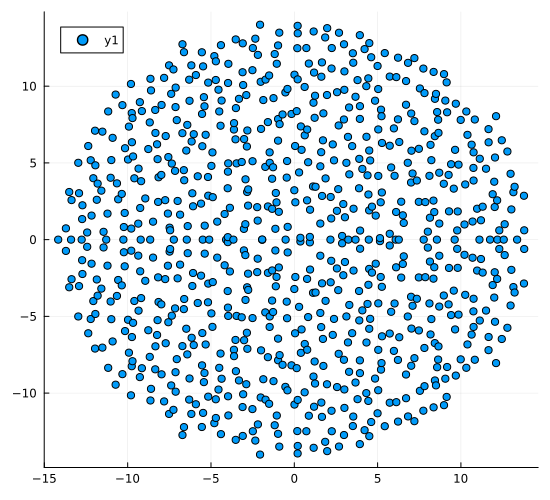

In [21]:
ev = eigvals(rand_matrix)

scatter(real.(ev), imag.(ev),size=(550,500))